In [1]:
#! nvidia-smi
!conda install --yes pytorch==2.4.0

zsh:1: command not found: conda


In [2]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker

# # ps
# import pysindy as ps

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

# Set the vector field

In [4]:
def get_v(x):
    x = x[...,-1]
    return np.stack([3*x*np.exp(-2*x**2),3*x*np.exp(-2*x**2)-5*x],axis=-1)

In [5]:
dim = 1

# Dataset for X

In [6]:
X = np.random.uniform(-3,3,(10000,1))
get_v(X[0]),get_v(X[:2])

(array([ 1.29891681e-04, -1.16698103e+01]),
 array([[ 1.29891681e-04, -1.16698103e+01],
        [-7.09548695e-01,  3.12514508e+00]]))

# Set the NN model and Solver with training process

In [7]:
def relu2(X): return func.relu(X)**2
def tanh(X): return func.tanh(X)
class FCNN(nn.Module):
    def __init__(self,input_dim=2,output_dim=1,num_hidden=2,hidden_dim=10,act=func.tanh,transform=None):
        super().__init__()
         
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers  = nn.ModuleList([nn.Linear(input_dim,hidden_dim)])
        for _ in range(num_hidden-1): self.layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.act     = act
        self.out     = nn.Linear(hidden_dim,output_dim)
        self.transform = transform
    def forward(self,X):
        if self.transform is not None: X = self.transform(X)
        for layer in self.layers: X = self.act(layer(X))
        Y = self.out(X)
        return Y
class Model(nn.Module):
    def __init__(self,dim,model_U,unit_len=int(5e3)):
        super().__init__()
        self.dim      = dim
        self.model_U  = model_U
        self.unit_len = unit_len
        self.mu       = nn.Parameter(torch.tensor([0.]*dim),requires_grad=False)
        self.sigma    = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        self.coef_U   = nn.Parameter(torch.tensor(1.),requires_grad=False)
        #self.mu       = nn.Parameter(torch.tensor([0.]*dim).cuda(),requires_grad=False)
        #self.sigma    = nn.Parameter(torch.tensor([1.]*dim).cuda(),requires_grad=False)
        #self.coef_U   = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=False)
    def get_U_harmonic(self,X): return torch.sum(X**2,axis=-1)
    def get_U_dU(self,X): 
        I = int(np.ceil(len(X)/self.unit_len))
        U,dU = [],[]
        for i in range(I):
            X_sub = X[i*self.unit_len:(i+1)*self.unit_len]
            if not torch.is_tensor(X_sub): X_sub = torch.tensor(X_sub,requires_grad=True)#.cuda()
            X_    = (X_sub-self.mu)/self.sigma
            U_    = self.coef_U*(self.model_U(X_).view(-1) + self.get_U_harmonic(X_))
            dU_   = torch.autograd.grad(U_,X_sub,torch.ones_like(U_),create_graph=True)[0] # it is X_sub!!!
            U.append(U_)
            dU.append(dU_)
        U = torch.hstack(U)
        dU = torch.vstack(dU)
        return U,dU
    def get_U_np(self,X): 
        U,_ = self.get_U_dU(X);
        return U.cpu().data.numpy()
class Solver():
    def __init__(self,model):
        self.model=model
    def train_model(self,data_train,data_test,get_loss,optimizer,
                    n_steps,batch_size,scheduler=None,n_show_loss=100,error_model=None,use_tqdm=True):
        if use_tqdm: step_range = tqdm(range(n_steps))
        else: step_range = range(n_steps)
        loss_step = []
        for i_step in step_range:
            if i_step%n_show_loss==0:
                loss_train,loss_test = get_loss(self.model,data_train)[:-1],\
                                       get_loss(self.model,data_test)[:-1]
                
                def show_num(x): 
                    if abs(x)<100 and abs(x)>.01: return '%0.5f'%x
                    else: return '%0.2e'%x
                item1 = '%2dk'%np.int_(i_step/1000)
                item2 = 'Loss: '+' '.join([show_num(k) for k in loss_train])
                item3 = ' '.join([show_num(k) for k in loss_test])
                item4 = ''
                if error_model is not None: item4 = 'E(QP): %0.4f' % (error_model(self.model))
                print(', '.join([item1,item2,item3,item4]))
                loss_step = loss_step + [i_step] + [k.cpu().data.numpy() for k in loss_train]\
                                                 + [k.cpu().data.numpy() for k in loss_train]
            data_batch = data_train[random.sample(range(len(data_train)),
                                                  min(batch_size,len(data_train)))]
#             print(i_step,data_batch.shape)
            loss = get_loss(self.model,data_batch)[-1]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
        if error_model is not None: 
            print("Error: %0.5f" % (error_model(self.model)))
        return loss_step

In [8]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U);#.cuda();
SOL     = Solver(model)

In [9]:
model.get_U_dU(X[:3])

(tensor([5.2689, 0.6281, 1.5311], grad_fn=<CatBackward0>),
 tensor([[ 4.6441],
         [-1.6009],
         [-2.4667]], grad_fn=<CatBackward0>))

# Set the loss function and Train the model for differen a_k(x)

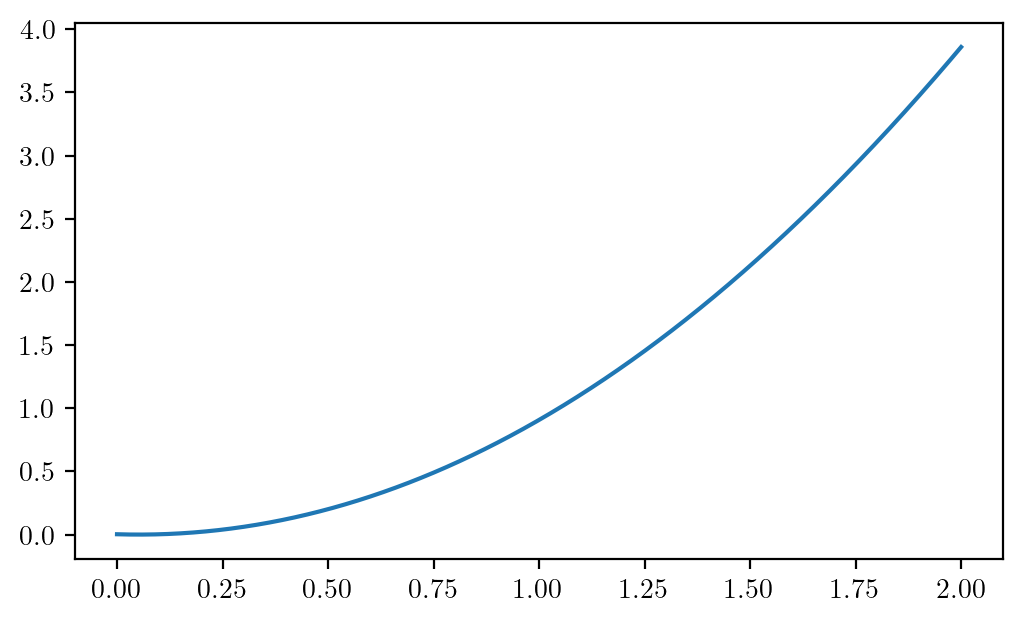

(tensor(171331.9423, grad_fn=<MeanBackward0>),
 tensor(171331.9423, grad_fn=<MeanBackward0>))

In [10]:
def plot_model(model,cmap='terrain',max_V = 10):
    
    xx     = np.linspace(0,2,1000).reshape(-1,1)
    U_NN   = model.get_U_np(xx)
    U_NN_min = U_NN.min()
    U_NN  = U_NN-U_NN_min

    fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
    c      = ax.plot(xx[:,0],U_NN,'-',lw=1.5,)

    ax.tick_params(axis="both", labelsize=10)
    plt.show()
#def get_a(X,k=choose_id):
#    if choose_id==1: return 2*torch.exp(-3*X**2)
#    if choose_id==2: return 2/(1+torch.exp(20*(torch.abs(X)-0.75)))
#    if choose_id==3: return 4/(1+torch.exp(20*(torch.abs(X)-0.75)))
def get_loss(model,data):

    X = data
    X = torch.tensor(X,requires_grad=True)#.cuda()
    _,dU = model.get_U_dU(X)

    param = 1 #controls speed of crosslink binding force 
    c = 0.5*param 
    
    tmp1 = torch.detach(3*X*torch.exp(-2*X**2)) #common part of v1 and v2, aka v1
    tmp2 = torch.detach(-2*param/(1+torch.exp(20*(torch.abs(X)-0.75)))) #affinity function no.2 
    tmp3 = torch.detach(-tmp2)
    tmp4 = torch.detach(tmp1-5*X) #v2 which includes the ``binding" force 
    Res = ( dU*(dU+tmp1)+tmp2 ) * (dU*(dU+tmp4)-c) - c*tmp3 #determinant 
    Res = Res**2
    #loss = (Res[0]+Res[1]+Res[2])/3
    loss = torch.mean( Res ) #norm of determinant -> loss function
    
    return loss,loss
plot_model(model)
get_loss(model,X[:3])

Parameter containing:
tensor([0.]) Parameter containing:
tensor([1.]) Parameter containing:
tensor(1.)


  0%|          | 0/100001 [00:00<?, ?it/s]

 0k, Loss: 4.28e+05, 4.28e+05, 
 1k, Loss: 5.07e+02, 5.07e+02, 
 2k, Loss: 1.20e+02, 1.20e+02, 
 3k, Loss: 34.21186, 34.21186, 
 4k, Loss: 11.03651, 11.03651, 
 5k, Loss: 4.05452, 4.05452, 
 6k, Loss: 1.72058, 1.72058, 
 7k, Loss: 0.82506, 0.82506, 
 8k, Loss: 0.42998, 0.42998, 
 9k, Loss: 0.23878, 0.23878, 
10k, Loss: 0.14025, 0.14025, 
11k, Loss: 0.08820, 0.08820, 
12k, Loss: 0.05972, 0.05972, 
13k, Loss: 0.04409, 0.04409, 
14k, Loss: 0.03448, 0.03448, 
15k, Loss: 0.02781, 0.02781, 
16k, Loss: 0.02271, 0.02271, 
17k, Loss: 0.01797, 0.01797, 
18k, Loss: 0.01265, 0.01265, 
19k, Loss: 8.34e-03, 8.34e-03, 
20k, Loss: 6.02e-03, 6.02e-03, 
21k, Loss: 5.25e-03, 5.25e-03, 
22k, Loss: 5.00e-03, 5.00e-03, 
23k, Loss: 4.76e-03, 4.76e-03, 
24k, Loss: 4.31e-03, 4.31e-03, 
25k, Loss: 3.68e-03, 3.68e-03, 
26k, Loss: 2.96e-03, 2.96e-03, 
27k, Loss: 2.08e-03, 2.08e-03, 
28k, Loss: 1.24e-03, 1.24e-03, 
29k, Loss: 7.17e-04, 7.17e-04, 
30k, Loss: 2.14e-04, 2.14e-04, 
31k, Loss: 1.93e-04, 1.93e-04, 
32k,

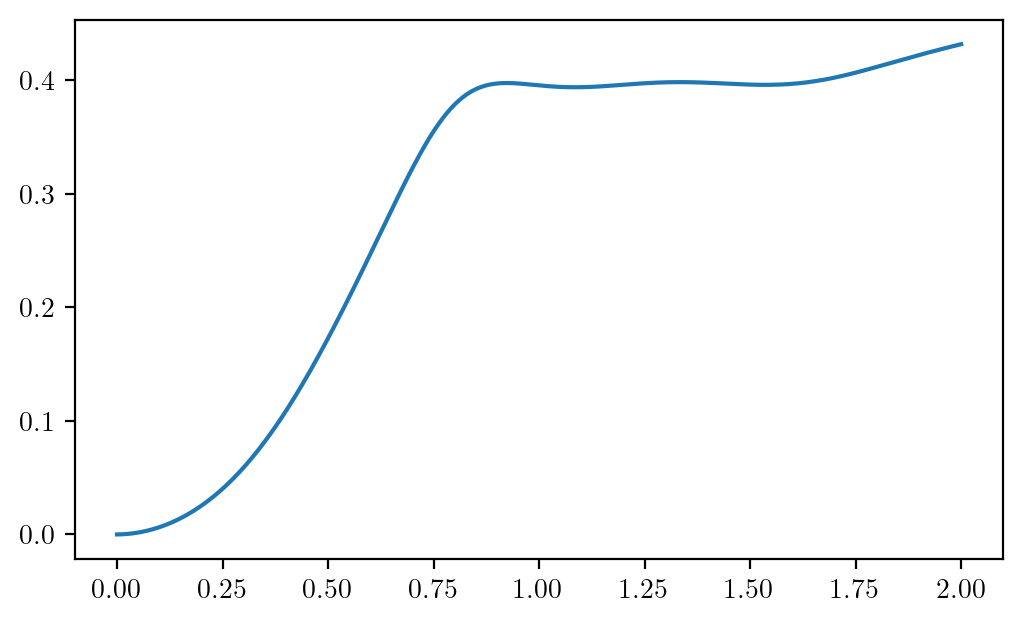

In [11]:
#for choose_id in [1,2,3]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U);#.cuda();
SOL     = Solver(model)

print(model.mu,model.sigma,model.coef_U)
optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001))#.cuda())
scheduler = None
_loss_step = SOL.train_model(data_train=X,data_test=X,
                                get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                                n_steps=int(10e4+1),batch_size=500,n_show_loss=1000,use_tqdm=True)
torch.cuda.empty_cache()
plot_model(model)
#torch.save(model.state_dict(), "savee/model_"+str(choose_id))

# Visualizing the results for different a_k(x)

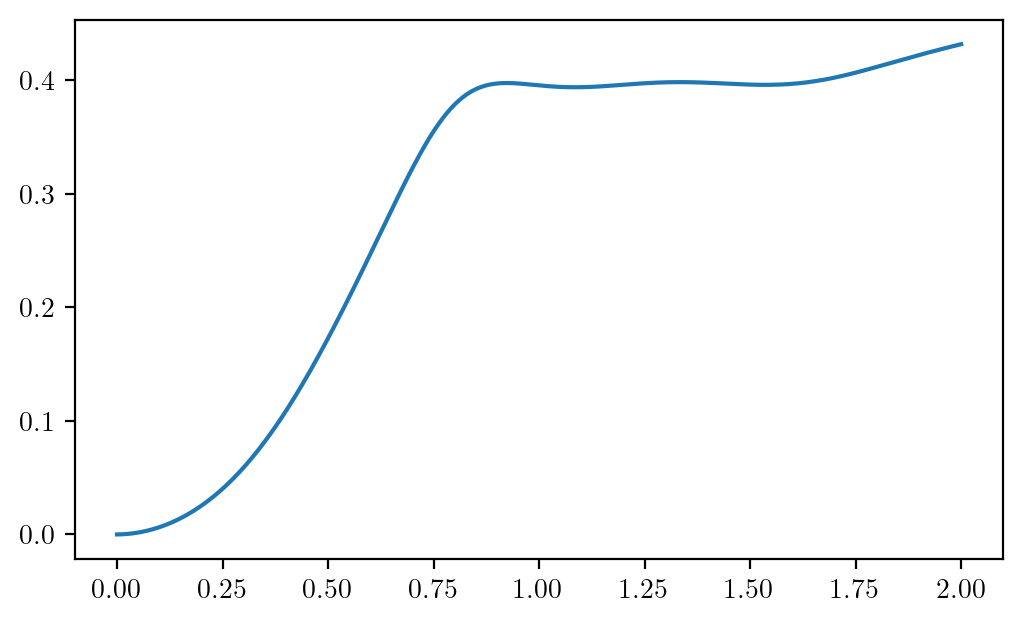

In [12]:
def plot_models(models):
    
    xx       = np.linspace(0,2,1000).reshape(-1,1)
    fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
    
    for k,model_name in enumerate(models):
        model.load_state_dict(torch.load(model_name))
        U_NN     = model.get_U_np(xx)
        U_NN_min = U_NN.min()
        U_NN     = U_NN-U_NN_min
        c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5,label="$a_{%d}(x)$"%(k+1))
    ax.legend(fontsize=10)
    ax.set_xlabel('$x$',fontsize=10)
    ax.set_ylabel('$U(x)$',fontsize=10)
    ax.set_xlim([0,2])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
    ax.set_xticks([0,.5,1.,1.5,2])
    ax.yaxis.grid(linestyle='--')
    ax.tick_params(axis="both", labelsize=10)
    plt.show()
    
plot_model(model)
    #["savee/model_1","savee/model_2","savee/model_3"])